In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix


In [2]:
# ############# Préprocessing #############
# Lecture du fichier
data = pd.read_csv('Data/Water Quality Prediction.csv')

#
#data = data.drop('Index', axis=1)  # On retire index qui sert à rien
data.info()
print(data.nunique())

###On les drop pour l'instant mais à terme on pourra gerer source et color
features_to_drop = ['Index','Month','Day','Time of Day']
#features_to_drop = ['Index', 'Color', 'Source','Month','Day','Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            1019772 non-null  float64
 14  Ch

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


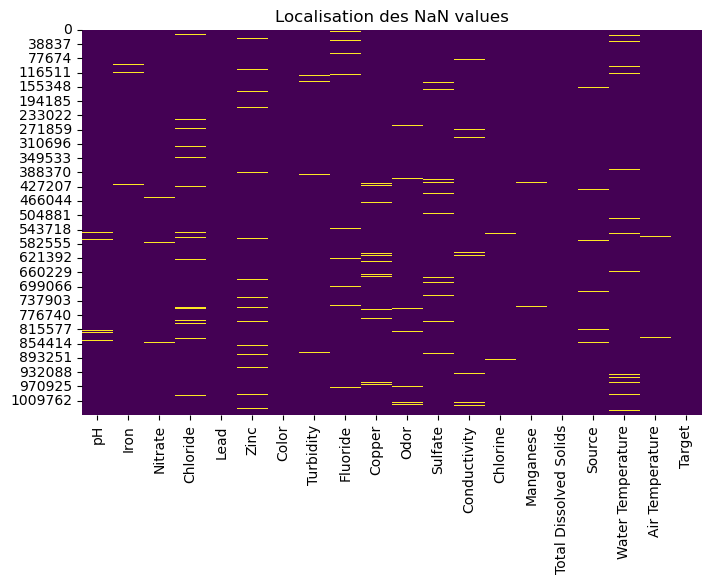

In [3]:
# Visualisation des NaN values
plt.figure(figsize=(8, 5))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")
plt.show()

Target
0    807841
1    240734
Name: count, dtype: int64


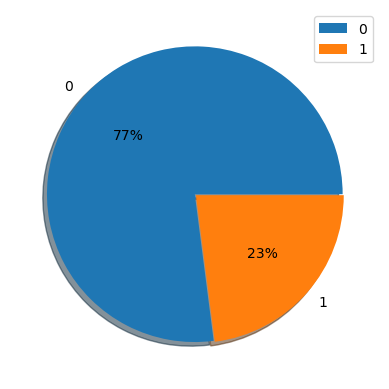

In [4]:
tar = data['Target'].value_counts()
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

In [5]:
#Calcul du pourcentage de Nan values pour voir si on peut les retirer ou s'il faut les remplacer
n=data.shape[0]
print("Before dropping rows with NA values:\n", data.shape[0])
#Dropping rows with NA values
dataa = data.copy()
dataa = dataa.dropna(how='any')
print("After dropping rows with NA values:\n", dataa.shape[0])
print("percentage of na value ",((n-dataa.shape[0])/n)*100,'%') #On peut pas juste retirer les Nan values



Before dropping rows with NA values:
 1048575
After dropping rows with NA values:
 739148
percentage of na value  29.50928641251222 %


In [ ]:
#On retire les Nan values quand on peut pas faire autrement et on les fill pour les valeurs quantitatives
data.dropna(subset=['Color', 'Source'], inplace=True)
data.reset_index(drop=True, inplace=True)
print("Avant drop et fil :", data.isnull().sum())

Avant drop et fil : pH                        19924
Iron                       6876
Nitrate                   18417
Chloride                  30340
Lead                       4616
Zinc                      27241
Color                         0
Turbidity                  8559
Fluoride                  32690
Copper                    34285
Odor                      30833
Sulfate                   33991
Conductivity              28362
Chlorine                   9985
Manganese                 19026
Total Dissolved Solids      294
Source                        0
Water Temperature         29202
Air Temperature            5220
Target                        0
dtype: int64


In [ ]:
###### Data quanti
data_num = data.select_dtypes(include=['float64', 'int64'])
data_num.fillna(data_num.mean(), inplace=True)


####### Data quali

#On transforme les variables quali en quanti binaire
df_cat = data.select_dtypes(include=['object']).copy() 
df_cat['Color'] = df_cat['Color'].astype('category')
df_cat['Source'] = df_cat['Source'].astype('category')

cat_encoder = OneHotEncoder(sparse_output=False)
df_cat_1hot = cat_encoder.fit_transform(df_cat)

# Créer un DataFrame avec les noms des colonnes générés par l'encodeur
df_cat_1hot_df = pd.DataFrame(df_cat_1hot, columns=cat_encoder.get_feature_names_out(df_cat.columns))


###### Assemblage quanti et quali

df = pd.concat([data_num, df_cat_1hot_df], axis = 1)
df.head()


,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,...,Color_Near Colorless,Color_Yellow,Source_Aquifer,Source_Ground,Source_Lake,Source_Reservoir,Source_River,Source_Spring,Source_Stream,Source_Well
0,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,0.019007,0.622874,0.437835,1.686049,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,0.319956,0.423423,0.431588,3.414619,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,0.166319,0.208454,0.239451,1.772712,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,0.004867,0.222912,0.616574,0.795310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7.449720,0.000006,1.702584,162.828458,6.100000e-23,3.742464,0.504791,0.054562,0.851326,1.270483,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
data.describe().loc[['min', 'mean', 'std', 'max']].T.style.background_gradient(axis=1)

,min,mean,std,max
pH,0.000000,0.497668,0.077494,1.000000
Iron,0.000000,0.007235,0.028060,1.000000
Nitrate,0.000000,0.079581,0.042634,1.000000
Chloride,0.000000,0.108814,0.046231,1.000000
Lead,0.000000,0.000367,0.008599,1.000000
Zinc,0.000000,0.053885,0.052350,1.000000
Turbidity,0.000000,0.025051,0.044421,1.000000
Fluoride,0.000000,0.073211,0.060661,1.000000
Copper,0.000000,0.043379,0.048905,1.000000
Odor,0.000000,0.426462,0.250640,1.000000


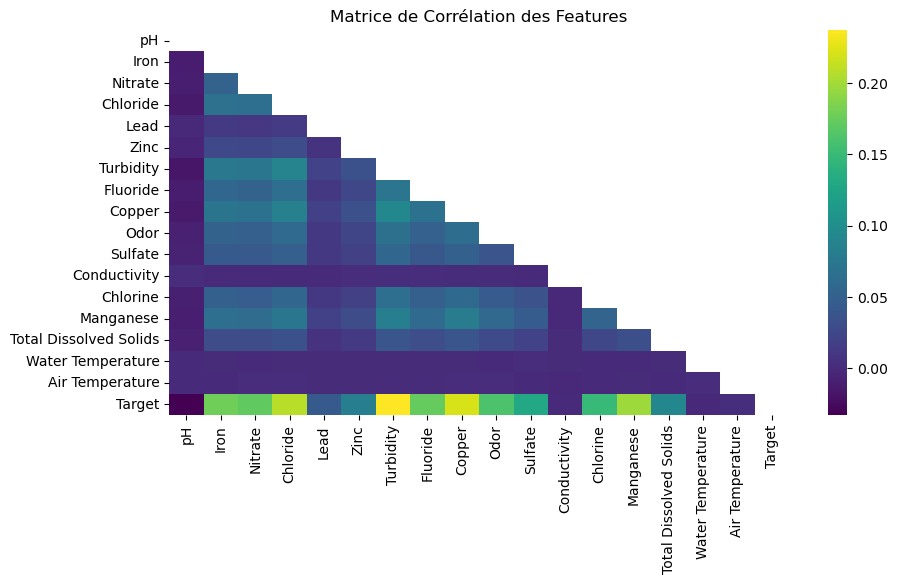

In [10]:
# Vérification des corrélations entre les features (que pour les quanti, pas de sens pour les quali)
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(data_num.corr(numeric_only=True), dtype=bool))
sns.heatmap(
    data_num.corr(numeric_only=True),
    annot=False, cmap="viridis", mask=mask, cbar=True
)
plt.title("Matrice de Corrélation des Features")
plt.show()

In [11]:
print("Après fill :",data.isnull().sum())  #pk ya des valeurs nulles là ????

Après fill : pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Water Temperature         0
Air Temperature           0
Target                    0
Color_Colorless           0
Color_Faint Yellow        0
Color_Light Yellow        0
Color_Near Colorless      0
Color_Yellow              0
Source_Aquifer            0
Source_Ground             0
Source_Lake               0
Source_Reservoir          0
Source_River              0
Source_Spring             0
Source_Stream             0
Source_Well               0
dtype: int64


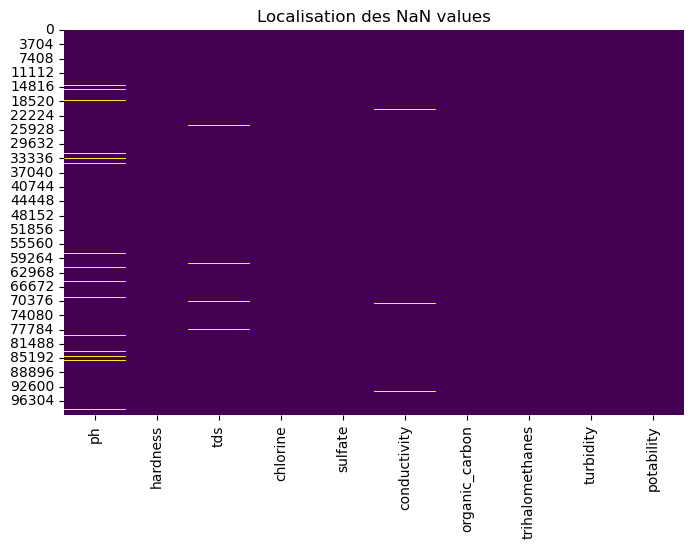

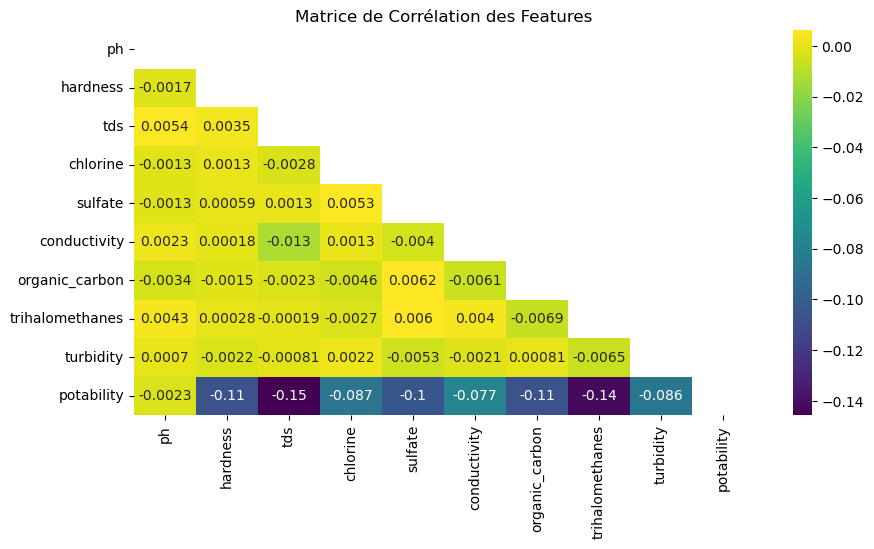

Comparaison des Modèles :
                      Accuracy       AUC  F1 Score
Logistic Regression  0.923185  0.884608  0.187858
Decision Tree        0.999512  0.997403  0.996731
Random Forest        0.999567  0.999996  0.997093
K-Nearest Neighbors  0.939437  0.921451  0.558452

Le meilleur modèle est : Random Forest


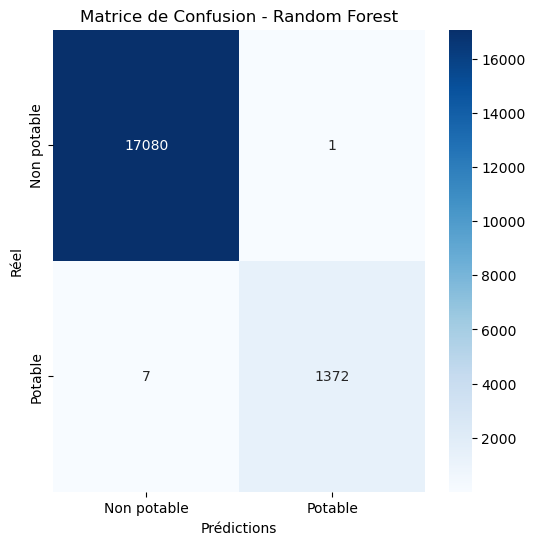


Classification Report pour Random Forest :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17081
           1       1.00      0.99      1.00      1379

    accuracy                           1.00     18460
   macro avg       1.00      1.00      1.00     18460
weighted avg       1.00      1.00      1.00     18460



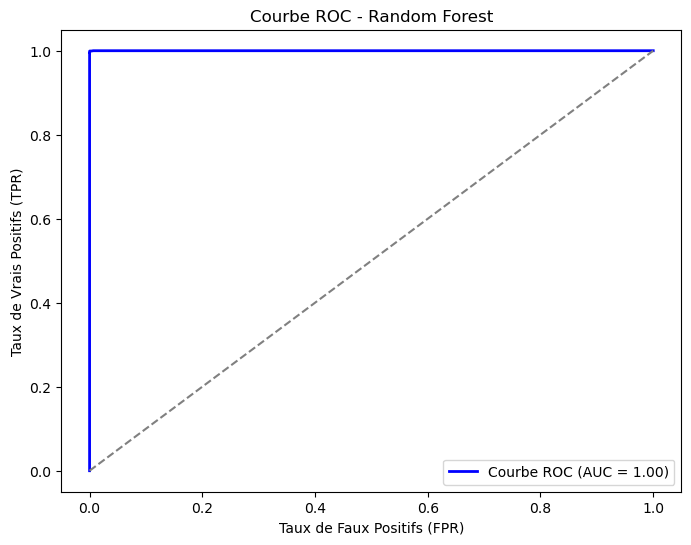

In [ ]:




# Séparation des données
X = data.drop('potability', axis=1)  # Toutes les colonnes sauf 'potability'
y = data['potability']              # Colonne cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ############# Modélisation et sélection du meilleur modèle #############

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Dictionnaire pour stocker les résultats de performance
results = {}

# Entraînement et évaluation des modèles
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1 (potable)

    # Calcul des métriques
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc_score = auc(*roc_curve(y_test, y_probs)[:2])  # AUC de la courbe ROC
    f1 = metrics.f1_score(y_test, y_pred)
    
    # Stockage des résultats
    results[model_name] = {
        'Accuracy': accuracy,
        'AUC': auc_score,
        'F1 Score': f1
    }

# Affichage des résultats pour comparer les modèles
results_df = pd.DataFrame(results).T
print("Comparaison des Modèles :\n", results_df)

# Sélection du meilleur modèle basé sur l'AUC (ou une autre métrique comme Accuracy ou F1 Score)
best_model_name = results_df['AUC'].idxmax()  # Choisir le modèle avec la meilleure AUC
best_model = models[best_model_name]

print(f"\nLe meilleur modèle est : {best_model_name}")

# ############# Évaluation du meilleur modèle #############

# Prédictions et évaluation du meilleur modèle
y_pred_best = best_model.predict(X_test)
y_probs_best = best_model.predict_proba(X_test)[:, 1]

# Matrice de confusion
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Non potable', 'Potable'], yticklabels=['Non potable', 'Potable'])
plt.title(f"Matrice de Confusion - {best_model_name}")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

# Classification Report
print(f"\nClassification Report pour {best_model_name} :")
print(classification_report(y_test, y_pred_best))

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # La ligne diagonale
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title(f'Courbe ROC - {best_model_name}')
plt.legend(loc='lower right')
plt.show()
